In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#я скопировал селебов к себе на диск, собственно с него и забираю
!unzip /content/drive/MyDrive/img_align_celeba.zip -d /content
!cp /content/drive/MyDrive/celeba_list_landmarks_align.txt /content

In [5]:
import pandas as pd
drive = '/content/drive/MyDrive'

In [6]:
df_identity = pd.read_csv(f'{drive}/celeba_identity.txt', header=None, names=['id', 'cls'], sep='\s+')
df_bbox = pd.read_csv(f'{drive}/celeba_list_bbox.txt', header=1, sep='\s+')
df_landmarks = pd.read_csv(f'{drive}/celeba_list_landmarks_align.txt', header=1, sep='\s+')
df_bbox.set_index('image_id', inplace=True)
image_dir = '/content/img_align_celeba/'

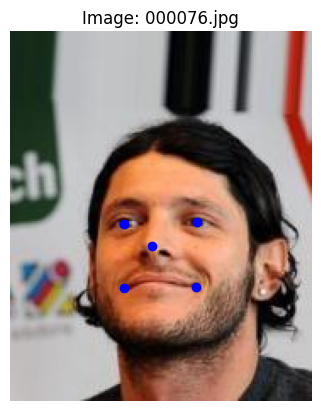

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image


def draw_image(img, landmarks, pred_landmarks=None):
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Landmark точки
    for i in range(0, len(landmarks)):
        x = landmarks[i][0]
        y = landmarks[i][1]
        ax.plot(x, y, 'bo')  # синяя точка

    if not pred_landmarks is None:
        for i in range(0, len(pred_landmarks)):
            x = pred_landmarks[i][0]
            y = pred_landmarks[i][1]
            ax.plot(x, y, 'ro')  # красная точка


    ax.set_title(f"Image: {img_id}")
    plt.axis('off')
    plt.show()


img_id = "000006.jpg"
img_id = f"{random.randint(1, 100):06d}.jpg"
img_path = image_dir + img_id

img = Image.open(img_path)
landmark_names = ['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
              'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']
landmarks = []
for i in range(0, len(landmark_names), 2):
    landmarks.append([df_landmarks.loc[img_id][landmark_names[i]],
                     df_landmarks.loc[img_id][landmark_names[i+1]]])
#landmarks = df_landmarks.loc[img_id]

draw_image(img, landmarks)


Собственно структура модели описана далее:

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)


class HourglassBlock(nn.Module):
    def __init__(self, channels, depth=4):
        super().__init__()
        self.depth = depth
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()

        for _ in range(depth):
            self.down.append(ResidualBlock(channels, channels))

        self.bottleneck = ResidualBlock(channels, channels)

        for _ in range(depth):
            self.up.append(ResidualBlock(channels, channels))

    def forward(self, x):
        skips = []
        for i in range(self.depth):
            x = self.down[i](x)
            skips.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)

        for i in reversed(range(self.depth)):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = self.up[i](x)
            x = x + skips[i]  # skip connection from encoder

        return x


class StackedHourglassNetwork(nn.Module):
    def __init__(self, in_channels=3, num_keypoints=68, num_stacks=2, channels=256, depth=4):
        super().__init__()
        self.preprocess = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            ResidualBlock(128, 128),
            ResidualBlock(128, channels),
        )

        self.hourglasses = nn.ModuleList([
            HourglassBlock(channels, depth=depth) for _ in range(num_stacks)
        ])

        self.out_heads = nn.ModuleList([
            nn.Conv2d(channels, num_keypoints, kernel_size=1) for _ in range(num_stacks)
        ])

        self.intermediate = nn.ModuleList()
        for _ in range(num_stacks - 1):
            self.intermediate.append(nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=1),
                nn.Conv2d(num_keypoints, channels, kernel_size=1)
            ))

    def forward(self, x):
        x = self.preprocess(x)
        outputs = []

        for i, hg in enumerate(self.hourglasses):
            y = hg(x)
            out = self.out_heads[i](y)
            outputs.append(out)

            if i < len(self.intermediate):
                inter = self.intermediate[i]
                x = x + inter[0](y) + inter[1](out)

        return outputs  # список предсказаний с каждого hourglass


In [ ]:
sgn = StackedHourglassNetwork()
sgn

StackedHourglassNetwork(
  (preprocess): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ResidualBlock(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ResidualBlock(
      (skip): Identity()
   

In [9]:
from torchvision import transforms
from torchvision.transforms import functional as F_v
from PIL import Image
import torch
import albumentations as A
import numpy as np
import cv2

class AlbumentationsAdapter:
    def __init__(self, transform, keypoint_params=None):
        self.transform = A.Compose(transform, keypoint_params=keypoint_params)

    def __call__(self, img, landmarks):
        augmented = self.transform(image=img, keypoints=landmarks)
        return augmented['image'], augmented['keypoints']

class PadAndResizeWithLandmarks:
    def __init__(self, target_size=256):
        self.target_size = target_size

    def __call__(self, img, landmarks):
        """
        img: PIL.Image
        landmarks: Tensor of shape (N, 2), where each row is (x, y)
        """
        img = np.asarray(img)

#        w, h = img.size
        h, w = img.shape[:2]
        max_side = max(w, h)

        # Compute padding
        pad_left = np.random.randint(0, max_side - w + 1)
        pad_top = np.random.randint(0, max_side - h + 1)
        pad_right = max_side - w - pad_left
        pad_bottom = max_side - h - pad_top

        # Pad image

        img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
#        img = F_v.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

        # Adjust landmarks after padding
        if isinstance(landmarks, torch.Tensor):
            landmarks = landmarks.clone()
        else:
            landmarks = torch.tensor(landmarks, dtype=torch.float32)

        landmarks[:, 0] += pad_left
        landmarks[:, 1] += pad_top

        # Resize image
        img = cv2.resize(img, (self.target_size, self.target_size), interpolation=cv2.INTER_LINEAR)
#        img = F_v.resize(img, (self.target_size, self.target_size))

        # Scale landmarks
        scale = self.target_size / max_side
        landmarks *= scale

        return img, landmarks

class ToTensor:
    def __call__(self, img, landmarks):
        # HWC → CHW
        img = img.transpose(2, 0, 1).astype('float32') / 255.0  # Нормализация в [0,1]
        return torch.from_numpy(img), torch.tensor(landmarks, dtype=torch.float32)

class NormalizeWithLandmarks:
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, img, landmarks):
        img = self.normalize(img)
        return img, landmarks

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, landmarks):
        for t in self.transforms:
            img, landmarks = t(img, landmarks)
        return img, landmarks

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Обратно нормализует тензор изображения [C, H, W]"""
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

In [10]:
from albumentations import (
    RandomBrightnessContrast, ShiftScaleRotate, HorizontalFlip,Rotate, GaussianBlur
)

train_transform = DualCompose([
    PadAndResizeWithLandmarks(target_size=256),
    AlbumentationsAdapter([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.8),
        RandomBrightnessContrast(p=0.5),
#        HorizontalFlip(p=0.5),
        GaussianBlur(p=0.2),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)),
    ToTensor(),
    NormalizeWithLandmarks(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

val_transform = DualCompose([
    PadAndResizeWithLandmarks(target_size=256),
    ToTensor(),
    NormalizeWithLandmarks(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CelebALandmarksDataset(Dataset):
    def __init__(self, root_dir, data, transform=None):
        """
        root_dir: путь к папке с изображениями
        transform: функция трансформации, принимающая (img, landmarks) -> (img_tensor, transformed_landmarks)
        """
        self.root_dir = root_dir
        self.transform = transform

        self.data = []
        for line in data:
            landmarks = torch.tensor([float(x) for x in line[1:]], dtype=torch.float32).view(-1, 2)
            self.data.append((line[0], landmarks))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, landmarks = self.data[idx]
        img_path = os.path.join(self.root_dir, filename)
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img, landmarks = self.transform(img, landmarks)

        return img, landmarks

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_landmarks, train_size=0.8, shuffle=True, random_state=42)

MAX_TRAIN = 5000
MAX_VAL   = 1000

train_data = CelebALandmarksDataset(
    root_dir=image_dir,
    data=df_train[:MAX_TRAIN].reset_index().values,
    transform=train_transform
)

val_data = CelebALandmarksDataset(
    root_dir=image_dir,
    data=df_val[:MAX_VAL].reset_index().values,
    transform=val_transform
)
print(len(train_data), len(val_data))


5000 1000


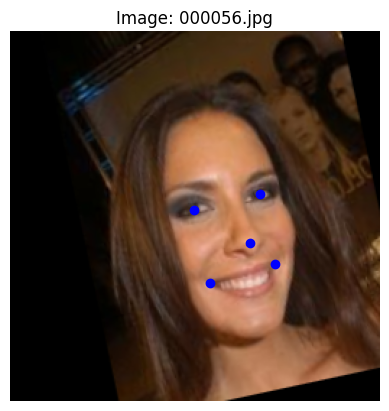

In [12]:
#здесь проверим работу аугментаций, важно убедиться что ландмарки модифицируются корректно
img, landmarks = train_data[10]
draw_image(denormalize(img).permute(1,2,0), landmarks)

Дальше блок для работы с хитмапами и координатами ландмарков.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def generate_heatmaps(landmarks, heatmap_size, image_size, sigma=2):
    """
    landmarks: (B, K, 2) — координаты keypoints
    heatmap_size: (H, W) — размер выходной карты
    image_size: (H_img, W_img) — размер изображения после трансформации (обычно 256×256)
    sigma: радиус гауссианы
    Возвращает: (B, K, H, W)
    """
    B, K, _ = landmarks.shape
    H, W = heatmap_size
    H_img, W_img = image_size

    heatmaps = torch.zeros((B, K, H, W), dtype=torch.float32)

    for b in range(B):
        for k in range(K):
            x, y = landmarks[b, k]
            x = x * W / W_img
            y = y * H / H_img

            xx, yy = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
            xx = xx.to(device)
            yy = yy.to(device)
            heatmap = torch.exp(-((xx - x) ** 2 + (yy - y) ** 2) / (2 * sigma ** 2))
            heatmaps[b, k] = heatmap

    return heatmaps

def heatmaps_to_coords(heatmaps):
    """
    Преобразует heatmaps (B, K, H, W) в координаты (B, K, 2) — (x, y)
    """
    B, K, H, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.view(B, K, -1)  # (B, K, H*W)
    max_inds = heatmaps_reshaped.argmax(dim=2)   # (B, K)

    # Преобразуем в координаты
    coords = torch.zeros(B, K, 2, device=heatmaps.device)
    coords[..., 0] = (max_inds % W).float()  # x
    coords[..., 1] = (max_inds // W).float()  # y
    return coords

def rescale_coords(coords, heatmap_size, image_size):
    """
    Скейлит координаты между разными размерами хитмапов и изображений
    """
    h, w = heatmap_size
    H, W = image_size
    scale_x = W / w
    scale_y = H / h
    coords[..., 0] *= scale_x
    coords[..., 1] *= scale_y
    return coords

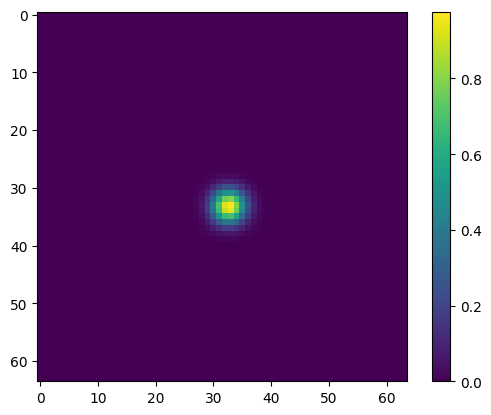

In [14]:
#проверяем генерацию хитмапа
img, landmarks = train_data[10]
gt_heatmaps = generate_heatmaps(landmarks.unsqueeze(0),(64,64),(256,256))
plt.imshow(gt_heatmaps[0, 0])
plt.colorbar()
plt.show()

Дальше простенький цикл обучения модели. Из важного для валидации я проверяю расстояние между предсказанными и тру ландмарками:

In [55]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, epochs=10):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                factor=0.5,      # во сколько раз уменьшать lr
                                patience=3,      # сколько эпох ждать без улучшения
                                verbose=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, landmarks in train_loader:
            images = images.to(device)                        # (B, 3, 256, 256)
            landmarks = landmarks.to(device)                  # (B, K, 2)

            preds = model(images)[-1]                             # (B, K, H, W)
            gt_heatmaps = generate_heatmaps(landmarks, preds.shape[2:], (256, 256)).to(device)
#            print(gt_heatmaps.shape)
            loss = F.mse_loss(preds, gt_heatmaps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(total_loss)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}, last_lr {scheduler.get_last_lr()}")

        model.eval()
        total_loss = 0.0
        total_distance = 0.0
        with torch.no_grad():
            for images, landmarks in val_loader:
                images = images.to(device)                        # (B, 3, 256, 256)
                landmarks = landmarks.to(device)                  # (B, K, 2)

                preds = model(images)[-1]                             # (B, K, H, W)
                gt_heatmaps = generate_heatmaps(landmarks, preds.shape[2:], (256, 256)).to(device)
                loss = F.mse_loss(preds, gt_heatmaps)

                total_loss += loss.item()

                coords = heatmaps_to_coords(preds.to('cpu'))
                rescaled_coords = rescale_coords(coords,(64,64),(256,256))
                dists = torch.norm(rescaled_coords - landmarks.to('cpu'))
                total_distance += dists.sum().item()

        avg_loss = total_loss / len(val_loader)
        avg_dist = total_distance / len(val_loader) / 5
        print(f"Epoch {epoch+1}/{epochs} — Val Loss: {avg_loss:.4f}, Avg Distance: {avg_dist:.4f}")


In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

In [17]:
#стартовый блок для обучения
model = StackedHourglassNetwork(num_stacks=2, num_keypoints=5)
train_model(model, train_loader, val_loader, epochs = 30)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 — Loss: 36.1686, last_lr [0.001]


/tmp/ipython-input-7-2842850771.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.from_numpy(img), torch.tensor(landmarks, dtype=torch.float32)


Epoch 1/30 — Val Loss: 0.3416, Avg Distance: 276.6599
Epoch 2/30 — Loss: 0.3395, last_lr [0.001]
Epoch 2/30 — Val Loss: 0.4692, Avg Distance: 282.4030
Epoch 3/30 — Loss: 0.1919, last_lr [0.001]
Epoch 3/30 — Val Loss: 0.2118, Avg Distance: 273.3324
Epoch 4/30 — Loss: 0.1422, last_lr [0.001]
Epoch 4/30 — Val Loss: 0.1054, Avg Distance: 275.2493
Epoch 5/30 — Loss: 0.1286, last_lr [0.001]
Epoch 5/30 — Val Loss: 0.1475, Avg Distance: 258.6203
Epoch 6/30 — Loss: 0.0944, last_lr [0.001]
Epoch 6/30 — Val Loss: 0.0595, Avg Distance: 257.4967
Epoch 7/30 — Loss: 0.0694, last_lr [0.001]
Epoch 7/30 — Val Loss: 0.0638, Avg Distance: 263.2562
Epoch 8/30 — Loss: 0.0587, last_lr [0.001]
Epoch 8/30 — Val Loss: 0.0890, Avg Distance: 266.4119
Epoch 9/30 — Loss: 0.1438, last_lr [0.001]
Epoch 9/30 — Val Loss: 0.0964, Avg Distance: 280.4317
Epoch 10/30 — Loss: 0.0462, last_lr [0.001]
Epoch 10/30 — Val Loss: 0.0488, Avg Distance: 269.6625
Epoch 11/30 — Loss: 0.0518, last_lr [0.001]
Epoch 11/30 — Val Loss: 0.0

In [20]:
train_model(model, train_loader, val_loader, epochs = 30)

Epoch 1/30 — Loss: 0.0541, last_lr [0.0001]


/tmp/ipython-input-7-2842850771.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.from_numpy(img), torch.tensor(landmarks, dtype=torch.float32)


Epoch 1/30 — Val Loss: 0.0108, Avg Distance: 255.1478
Epoch 2/30 — Loss: 0.0158, last_lr [0.0001]
Epoch 2/30 — Val Loss: 0.0064, Avg Distance: 236.2002
Epoch 3/30 — Loss: 0.0170, last_lr [0.0001]
Epoch 3/30 — Val Loss: 0.0109, Avg Distance: 222.0864
Epoch 4/30 — Loss: 0.0166, last_lr [0.0001]
Epoch 4/30 — Val Loss: 0.0063, Avg Distance: 196.9186
Epoch 5/30 — Loss: 0.0140, last_lr [0.0001]
Epoch 5/30 — Val Loss: 0.0112, Avg Distance: 204.1877
Epoch 6/30 — Loss: 0.0178, last_lr [0.0001]
Epoch 6/30 — Val Loss: 0.0093, Avg Distance: 199.2275
Epoch 7/30 — Loss: 0.0147, last_lr [0.0001]
Epoch 7/30 — Val Loss: 0.0087, Avg Distance: 182.7580
Epoch 8/30 — Loss: 0.0109, last_lr [0.0001]
Epoch 8/30 — Val Loss: 0.0071, Avg Distance: 161.2780
Epoch 9/30 — Loss: 0.0188, last_lr [0.0001]
Epoch 9/30 — Val Loss: 0.0184, Avg Distance: 180.4241
Epoch 10/30 — Loss: 0.0165, last_lr [0.0001]
Epoch 10/30 — Val Loss: 0.0062, Avg Distance: 155.6378
Epoch 11/30 — Loss: 0.0109, last_lr [0.0001]
Epoch 11/30 — Val

In [56]:
train_model(model, train_loader, val_loader, epochs = 10)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 — Loss: 0.0017, last_lr [1e-05]


/tmp/ipython-input-7-2842850771.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.from_numpy(img), torch.tensor(landmarks, dtype=torch.float32)


Epoch 1/10 — Val Loss: 0.0012, Avg Distance: 45.8928
Epoch 2/10 — Loss: 0.0016, last_lr [1e-05]
Epoch 2/10 — Val Loss: 0.0011, Avg Distance: 44.6485
Epoch 3/10 — Loss: 0.0015, last_lr [1e-05]
Epoch 3/10 — Val Loss: 0.0011, Avg Distance: 45.0797
Epoch 4/10 — Loss: 0.0015, last_lr [1e-05]
Epoch 4/10 — Val Loss: 0.0012, Avg Distance: 43.2553
Epoch 5/10 — Loss: 0.0015, last_lr [1e-05]
Epoch 5/10 — Val Loss: 0.0014, Avg Distance: 49.5591
Epoch 6/10 — Loss: 0.0016, last_lr [1e-05]
Epoch 6/10 — Val Loss: 0.0011, Avg Distance: 39.9434
Epoch 7/10 — Loss: 0.0014, last_lr [1e-05]
Epoch 7/10 — Val Loss: 0.0010, Avg Distance: 40.6261
Epoch 8/10 — Loss: 0.0015, last_lr [1e-05]
Epoch 8/10 — Val Loss: 0.0010, Avg Distance: 41.9562
Epoch 9/10 — Loss: 0.0014, last_lr [1e-05]
Epoch 9/10 — Val Loss: 0.0014, Avg Distance: 48.8161
Epoch 10/10 — Loss: 0.0014, last_lr [1e-05]
Epoch 10/10 — Val Loss: 0.0011, Avg Distance: 46.4852


In [57]:
torch.save(model.state_dict(), 'shg_e90_r46.pt')

In [14]:
model = StackedHourglassNetwork(num_stacks=2, num_keypoints=5)
model.load_state_dict(torch.load('checkpoints/shg_e90_r46.pt', map_location=torch.device(device)))
model = model.to(device)

Train landmarks: tensor([[ 93.7943, 132.0006],
        [134.2879, 137.8365],
        [ 95.3354, 160.0654],
        [ 88.6572, 183.1489],
        [124.5944, 189.5937]])
Predicted: tensor([[ 96., 136.],
        [132., 136.],
        [104., 164.],
        [ 92., 180.],
        [124., 184.]])


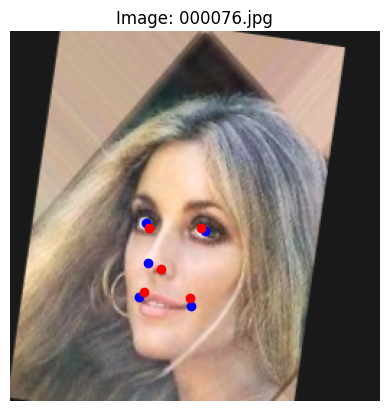

In [19]:
#посмотрим предсказания на трейн картинке
train_iter = iter(train_loader)
images, landmarks = next(train_iter)
preds = model(images.to(device))[-1]
coords = heatmaps_to_coords(preds.to('cpu'))
rescaled_coords = rescale_coords(coords,(64,64),(256,256))

print("Train landmarks:", landmarks[0])
print("Predicted:", rescaled_coords[0])
draw_image(denormalize(images[0]).permute(1,2,0), landmarks[0], rescaled_coords[0])

In [ ]:
print("Preds shape", preds.shape)

Preds shaoe torch.Size([10, 5, 64, 64])


/tmp/ipython-input-9-2842850771.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.from_numpy(img), torch.tensor(landmarks, dtype=torch.float32)


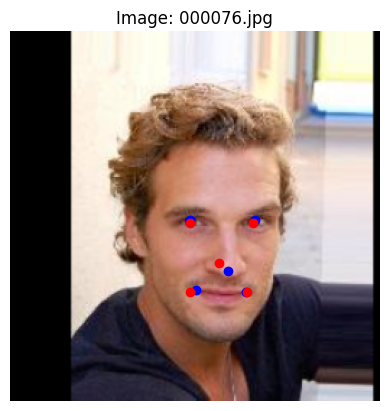

In [20]:
#предсказания на вал картинке
val_iter = iter(val_loader)
val_images, val_landmarks = next(val_iter)
preds = model(val_images.to(device))[-1]
val_coords = heatmaps_to_coords(preds.to('cpu'))
val_rescaled_coords = rescale_coords(val_coords,(64,64),(256,256))
#pred_landmarks =
idx = 2
draw_image(denormalize(val_images[idx]).permute(1,2,0), val_landmarks[idx], val_rescaled_coords[idx])

In [25]:
import math
def draw_images(images, ncols=4, figsize=(15, 16)):
    """
    images: list of tuples (img: np.ndarray or PIL, gt_landmarks: Tensor/array[N, 2], pred_landmarks: Tensor/array[N, 2] or None)
    """
    n = len(images)
    ncols = min(ncols, n)
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten() if n > 1 else [axs]

    for i, (img, landmarks, pred_landmarks) in enumerate(images):
        ax = axs[i]
        ax.imshow(img)
        ax.axis('off')
        pred_landmarks = pred_landmarks.to('cpu')

        # GT landmarks (blue)
        for (x, y) in landmarks:
            ax.plot(x, y, 'bo', markersize=3)

        # Predicted landmarks (red)
        if pred_landmarks is not None:
            for (x, y) in pred_landmarks:
                ax.plot(x, y, 'ro', markersize=3)

    # Удалим лишние пустые сабплоты
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


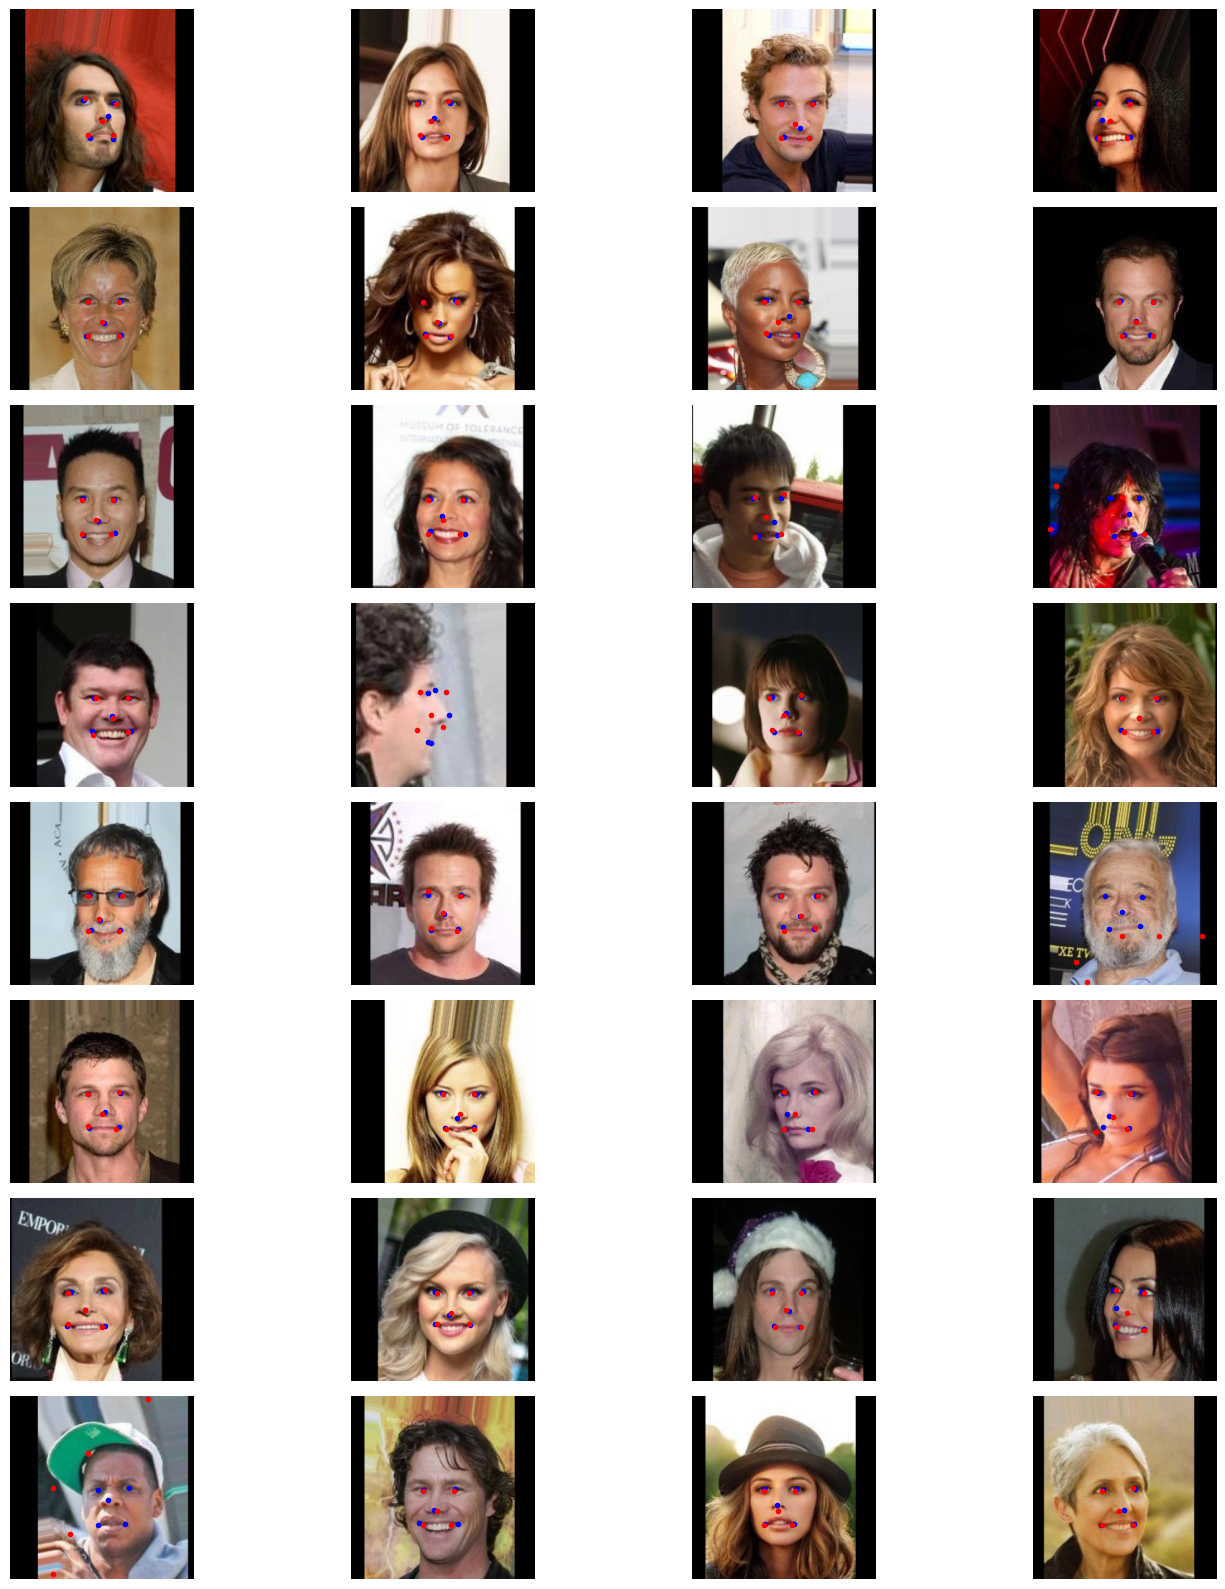

In [26]:
#еще картинки
img_data = []
pred_coords = rescale_coords(heatmaps_to_coords(preds).to('cpu'),(64,64),(256,256))
for i in range(len(val_images)):
    img_data.append((denormalize(val_images[i]).permute(1,2,0), val_landmarks[i], pred_coords[i]))
#draw_image(val_images[0].permute(1,2,0), val_landmarks[0], pred_coords[0])
#print(val_landmarks[0])
#print(pred_coords[0])
draw_images(img_data)

tensor([[ 0.0175,  0.0005, -0.0070,  ...,  0.0149,  0.0095, -0.0085],
        [ 0.0015,  0.0052,  0.0120,  ...,  0.0107,  0.0128,  0.0027],
        [ 0.0087,  0.0064,  0.0016,  ...,  0.0060,  0.0128,  0.0231],
        ...,
        [ 0.0098,  0.0154,  0.0049,  ...,  0.0017,  0.0071,  0.0064],
        [ 0.0018,  0.0055,  0.0091,  ...,  0.0077,  0.0087,  0.0174],
        [ 0.0060,  0.0029,  0.0133,  ...,  0.0162,  0.0034,  0.0162]],
       device='cuda:0', grad_fn=<SelectBackward0>)


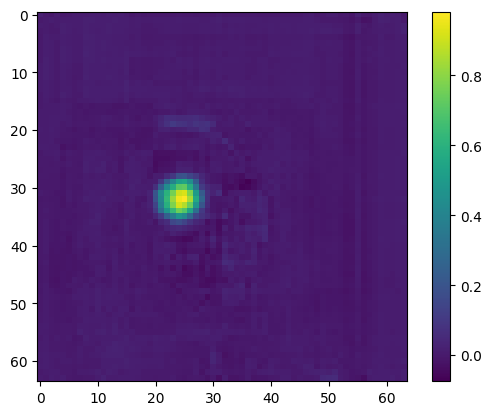

In [62]:
#здесь проверка предсказанного хитмапа
import matplotlib.pyplot as plt

print(preds[0, 0])
# heatmaps_pred: [B, K, H, W]
plt.imshow(preds[0, 0].detach().cpu())  # первый кейпоинт первой картинки
plt.colorbar()
plt.show()


In [29]:
def show_aligned_examples(pairs, figsize=(12, 8)):
    """
    pairs: список из [(orig_img, landmarks, aligned_img), ...]
    """

    n = min(len(pairs), 6)  # максимум 6 примеров
    fig, axs = plt.subplots(2, n, figsize=figsize)

    if n == 1:
        axs = [axs]  # в случае одной строки

    for i in range(n):
        orig_img, landmarks, aligned_img = pairs[i]

        # Оригинал с landmark'ами
        axs[0][i].imshow(orig_img)
        axs[0][i].set_title("Original")
        axs[0][i].axis('off')
        for (x, y) in landmarks:
            axs[0][i].plot(x, y, 'ro', markersize=3)

        # Выравненное лицо
        axs[1][i].imshow(aligned_img)
        axs[1][i].set_title("Aligned")
        axs[1][i].axis('off')

    plt.tight_layout()
    plt.show()

Далее афинные преобразования для выравнивания ключевых точек лица в соответствии с заданным стандартом

In [63]:
import cv2
import numpy as np

dst_size = (112,112)

dst = np.array([
    [38.2946, 51.6963],   # левый глаз
    [73.5318, 51.5014],   # правый глаз
    [56.0252, 71.7366],   # нос
    [41.5493, 92.3655],   # левый рот
    [70.7299, 92.2041]    # правый рот
])

aligned_data = []
for image, coords in zip(val_images, val_rescaled_coords):
    image = denormalize(image)
    coords_np = coords.cpu().numpy().astype(np.float32)
    M = cv2.estimateAffinePartial2D(coords_np, dst, method=cv2.LMEDS)[0]
    img_np = image.permute(1, 2, 0).cpu().numpy()
    aligned_img = cv2.warpAffine(img_np, M, (112, 112))
    aligned_data.append((img_np, coords_np, aligned_img))




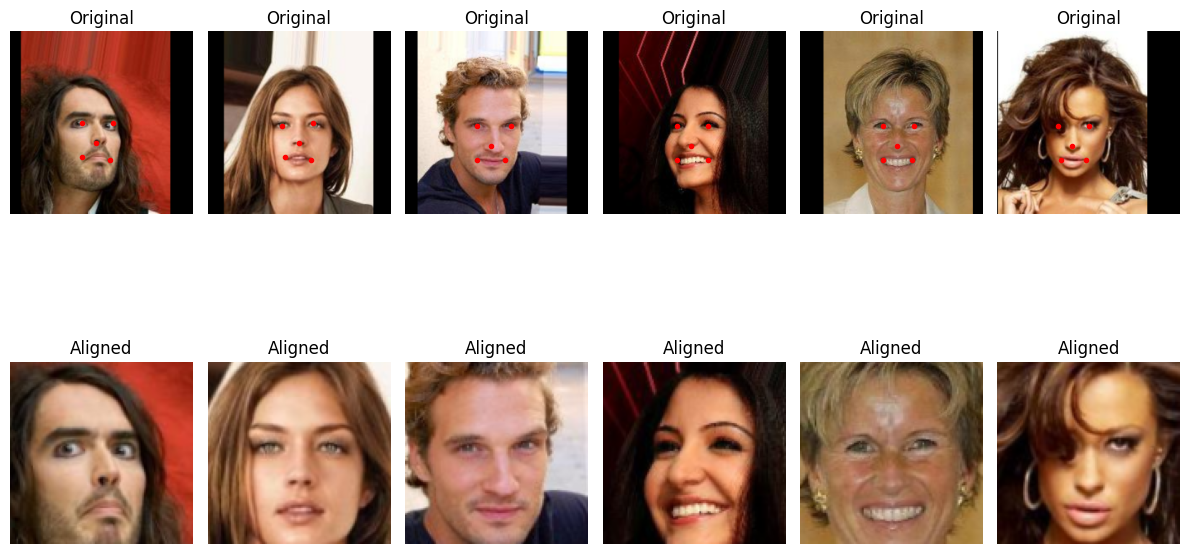

In [64]:
show_aligned_examples(aligned_data)